In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cvxpy as cp
from datetime import datetime
pd.set_option("display.max_columns", None)

In [22]:
close_prices = pd.read_csv('sp100_daily_value.csv', index_col=0, parse_dates=True)
daily_returns = pd.read_csv('sp100_daily_change.csv', index_col=0, parse_dates=True)

In [23]:
daily_returns.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-03 00:00:00-05:00,-0.007488,0.004005,-0.003004,-0.025942,-0.014274,-0.003341,-0.023524,0.011096,-0.018829,-0.009738,...,-0.014888,0.004988,-0.007107,-0.005052,-0.026418,-0.003438,0.007202,-0.013177,0.000063,0.008402
2024-01-04 00:00:00-05:00,-0.012700,0.006232,0.013331,-0.002456,-0.008290,0.000292,0.005099,0.008248,0.003587,-0.026268,...,-0.013614,0.006254,-0.002648,-0.003491,0.010760,0.006318,0.005363,0.012325,-0.009667,-0.008719
2024-01-05 00:00:00-05:00,-0.004013,0.004212,-0.001622,-0.001394,-0.004321,0.005537,0.018896,-0.000561,-0.005477,0.004634,...,0.003831,-0.014741,-0.004771,0.011020,0.013886,0.000308,0.021082,0.012987,-0.006656,0.003030
2024-01-08 00:00:00-05:00,0.024175,-0.004379,0.014440,0.011081,0.028250,-0.011448,0.054842,0.026007,0.008400,0.026577,...,0.020836,-0.001600,0.002959,0.007561,0.003424,0.010975,-0.002488,0.000000,0.009827,-0.016662


In [116]:
benchmark_weights = np.ones(len(daily_returns.columns)) / len(daily_returns.columns) #all stocks ave same weight
benchmark_returns = daily_returns.dot(benchmark_weights).values 

tickers = daily_returns.columns
n_stocks = len(tickers)
n_days = len(daily_returns)
q = 70  #Number of stocks to select

#Set Variables
weights = cp.Variable(n_stocks)
selected = cp.Variable(n_stocks, boolean=True)
portfolio_returns = daily_returns.values @ weights

#We waant to minimize tracking error variance
tracking_error = cp.sum_squares(portfolio_returns - benchmark_returns) / n_days

#Set OUr Constraints
constraints = [
    cp.sum(weights) == 1,
    weights >= 0.005 * selected,  #Min 0.5% if selected
    weights <= 0.2 * selected,   #Max 20% wieght if selected
    cp.sum(selected) == q, #Only q stock
]

#Solve
prob = cp.Problem(cp.Minimize(tracking_error), constraints)
prob.solve(solver=cp.ECOS_BB, max_iters=1000, verbose=True)

#Get + print Results
selected_stocks = tickers[selected.value > 0.5]
selected_weights = weights.value[selected.value > 0.5]

print(f"Selected {len(selected_stocks)} stocks:")
print(selected_stocks.tolist())
print("\nWeights:")
print({t: round(w, 4) for t, w in zip(selected_stocks, selected_weights)})
print(f"\nTracking Error Variance: {prob.value:.6f}")

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Apr 03 12:07:16 PM: Your problem has 200 variables, 202 constraints, and 0 parameters.
(CVXPY) Apr 03 12:07:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 03 12:07:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 03 12:07:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 03 12:07:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 03 12:07:16 PM: Compiling problem (target solver=ECOS_BB)

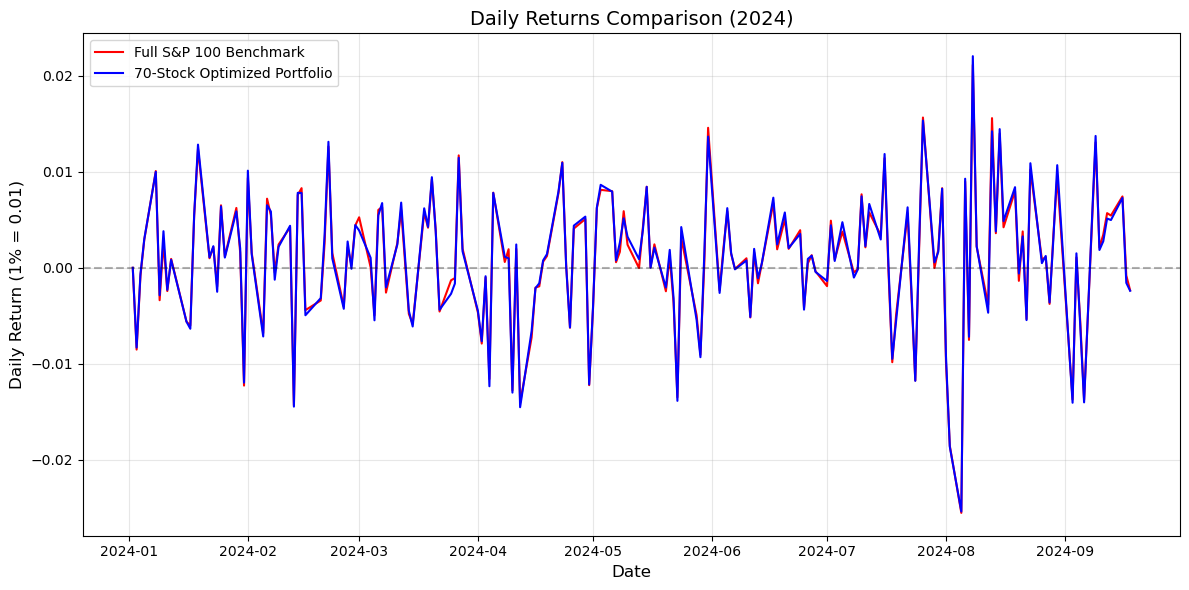

In [64]:
optimized_weights = pd.Series(weights.value, index=daily_returns.columns)
portfolio_returns = daily_returns @ optimized_weights

benchmark_weights = np.ones(len(daily_returns.columns)) / len(daily_returns.columns)
benchmark_returns = daily_returns @ benchmark_weights

#Performance df
performance = pd.DataFrame({
    'Benchmark': benchmark_returns,
    'Optimized_Portfolio': portfolio_returns
}, index=daily_returns.index)

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Benchmark', color='red', label='Full S&P 100 Benchmark') #Actual SP100 red
sns.lineplot(data=performance, x=performance.index, y='Optimized_Portfolio',color='blue', label='70-Stock Optimized Portfolio') #Our version blue
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Daily Returns Comparison (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

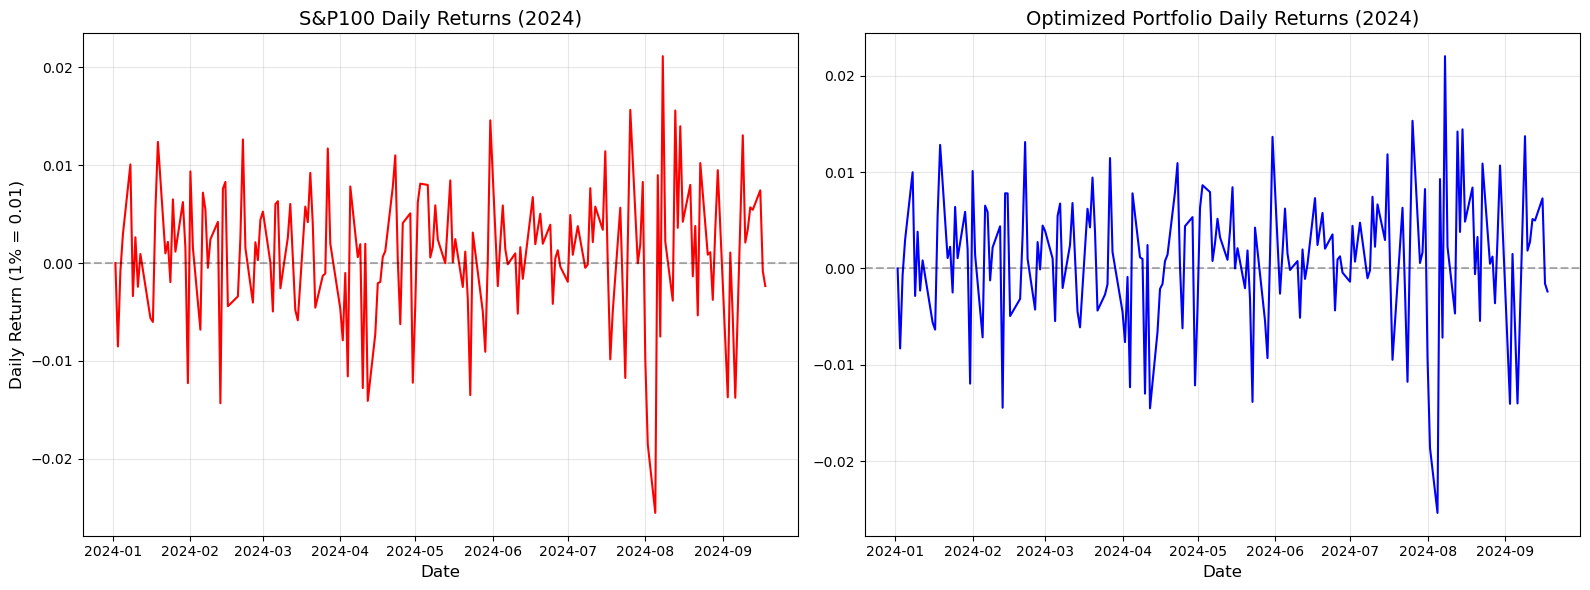

In [76]:
plt.figure(figsize=(16, 6))

#SP100
plt.subplot(1, 2, 1)  #pos1
sns.lineplot(data=performance, x=performance.index, y='Benchmark', color='red')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("S&P100 Daily Returns (2024)", fontsize=14)
plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

#OUr stocks
plt.subplot(1, 2, 2) #pos2
sns.lineplot(data=performance, x=performance.index, y='Optimized_Portfolio', color='blue')
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Optimized Portfolio Daily Returns (2024)", fontsize=14)
#plt.ylabel("Daily Return (1% = 0.01)", fontsize=12)
plt.ylabel("")
plt.xlabel("Date", fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Whats the difference?

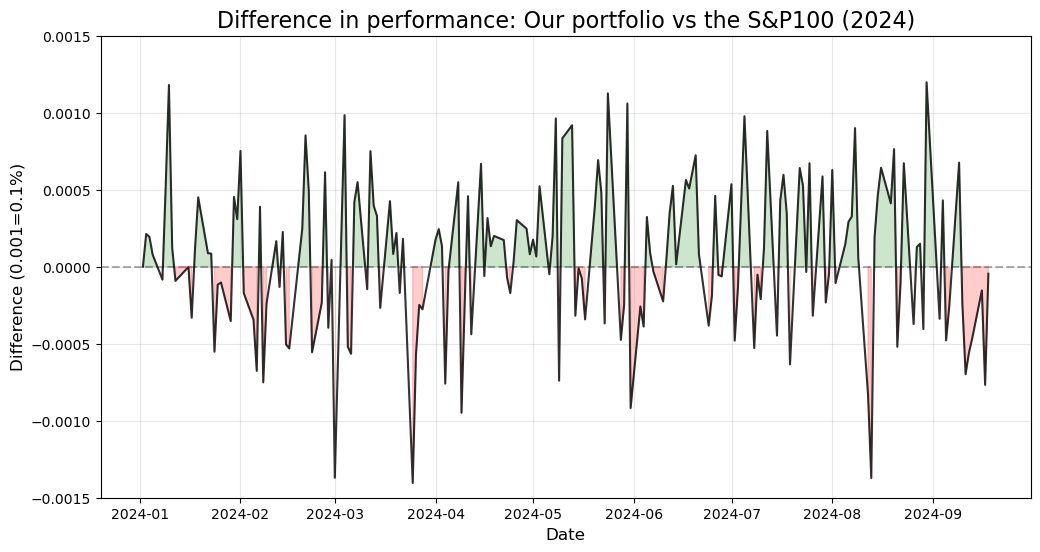

In [77]:
performance['Difference'] = performance['Optimized_Portfolio'] - performance['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (2024)", fontsize=16)
plt.ylabel("Difference (0.001=0.1%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.0015,0.0015)
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

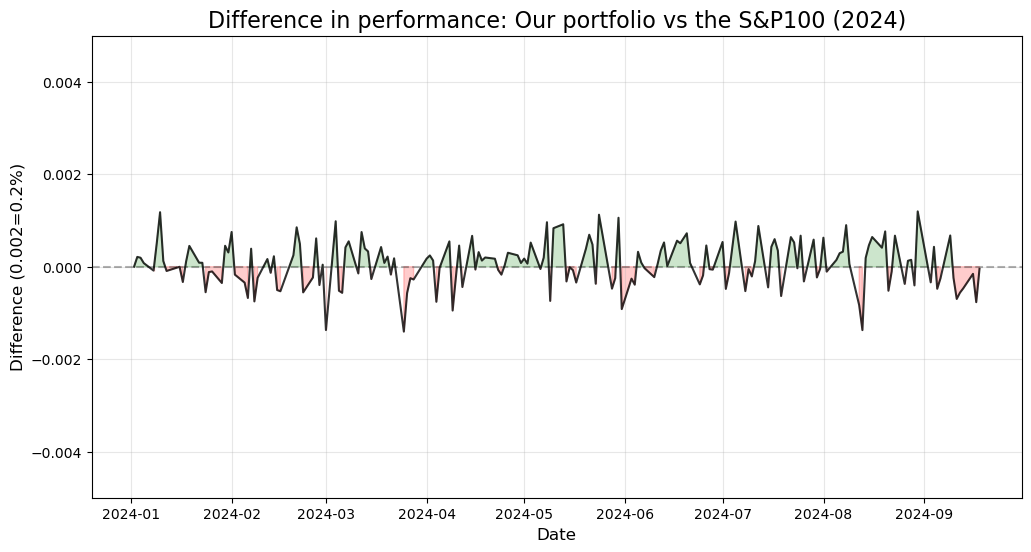

In [80]:
performance['Difference'] = performance['Optimized_Portfolio'] - performance['Benchmark']

#plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance, x=performance.index, y='Difference', 
             color='black', alpha=0.8)
plt.axhline(0, color="black", linestyle="--", alpha=0.3)
plt.title("Difference in performance: Our portfolio vs the S&P100 (2024)", fontsize=16)
plt.ylabel("Difference (0.002=0.2%)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.ylim(-0.005,0.005)
plt.grid(True, alpha=0.3)

#fill positive and negatives
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] > 0), 
                 color='green', alpha=0.2, interpolate=True)
plt.fill_between(performance.index, performance['Difference'], 0, 
                 where=(performance['Difference'] < 0), 
                 color='red', alpha=0.2)
plt.show()

## 1 quarter

In [106]:
daily_returns[0:61]#Q1

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BK,BKNG,BLK,BMY,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,DUK,EMR,FDX,GD,GE,GILD,GM,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDLZ,MDT,MET,META,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLTR,PM,PYPL,QCOM,RTX,SBUX,SCHW,SO,SPG,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-02 00:00:00-05:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-01-03 00:00:00-05:00,-0.007488,0.004005,-0.003004,-0.025942,-0.014274,-0.003341,-0.023524,0.011096,-0.018829,-0.009738,-0.024692,-0.010568,-0.031180,-0.010915,-0.011073,-0.020482,-0.020180,-0.008719,0.011312,-0.028732,-0.012362,-0.010283,-0.008244,-0.010521,0.019900,-0.009160,-0.016749,0.007781,0.000371,0.019066,-0.018857,-0.016951,0.010363,0.009917,-0.012516,-0.018237,-0.007966,-0.015006,0.002883,-0.021637,0.005732,0.005428,-0.016765,-0.019763,-0.021388,-0.008669,-0.015690,-0.020902,-0.026739,0.006251,-0.004359,0.002340,-0.002124,0.043060,0.006577,-0.029179,-0.007395,-0.008921,-0.007584,0.004346,-0.003415,-0.005256,-0.020091,-0.004329,0.013511,-0.021193,-0.000728,0.006822,0.003757,-0.023557,-0.017774,-0.012436,-0.015376,0.000231,0.000000,-0.006051,-0.029554,-0.001465,-0.046046,-0.018755,0.004576,-0.004697,-0.029667,0.019619,-0.020555,-0.001159,-0.030957,-0.028172,0.001050,-0.040134,-0.014888,0.004988,-0.007107,-0.005052,-0.026418,-0.003438,0.007202,-0.013177,0.000063,0.008402
2024-01-04 00:00:00-05:00,-0.012700,0.006232,0.013331,-0.002456,-0.008290,0.000292,0.005099,0.008248,0.003587,-0.026268,-0.009040,0.007646,0.004223,0.008053,0.004054,0.003130,0.002295,0.006577,0.002424,0.006331,-0.028241,0.005633,-0.015701,-0.007267,-0.028767,0.005677,-0.002382,-0.008513,-0.004575,-0.010963,-0.002441,0.007842,-0.011893,-0.002936,0.004436,-0.009490,-0.001403,0.004836,0.011979,0.006237,-0.016529,-0.018212,0.003039,0.000975,0.001809,0.004747,-0.003826,-0.007308,0.003539,-0.002112,0.006636,-0.003336,-0.000294,-0.005181,-0.002723,-0.004946,0.002388,-0.009002,0.000000,0.008774,0.005512,0.007693,0.003525,0.002899,0.019517,0.002611,-0.007178,-0.003065,0.009378,-0.016724,-0.005079,0.009019,0.001269,-0.008557,-0.021527,0.005479,0.009944,0.002515,-0.003070,-0.010393,-0.002336,0.003432,-0.002386,-0.007336,0.001213,-0.004643,0.011394,0.016149,0.001357,-0.002181,-0.013614,0.006254,-0.002648,-0.003491,0.010760,0.006318,0.005363,0.012325,-0.009667,-0.008719
2024-01-05 00:00:00-05:00,-0.004013,0.004212,-0.001622,-0.001394,-0.004321,0.005537,0.018896,-0.000561,-0.005477,0.004634,0.000257,0.010260,0.016575,0.018639,0.007306,-0.003450,-0.003970,0.003651,0.010415,0.009892,-0.009448,-0.004481,0.009618,0.020421,0.000429,0.011815,-0.000478,0.000200,0.011303,-0.001726,0.009098,-0.010016,0.003754,0.000508,0.003891,0.006197,-0.008900,0.013076,-0.013849,0.014089,-0.004709,-0.004839,0.009113,0.012847,-0.006686,-0.010568,0.000427,0.003749,-0.002382,0.003113,0.005017,-0.001506,0.001297,0.006591,-0.002992,0.006107,-0.000834,-0.009426,-0.002593,0.00762

## 2 quarters

In [110]:
daily_returns[62:124]

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BK,BKNG,BLK,BMY,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,DUK,EMR,FDX,GD,GE,GILD,GM,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDLZ,MDT,MET,META,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLTR,PM,PYPL,QCOM,RTX,SBUX,SCHW,SO,SPG,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-04-02 00:00:00-04:00,-0.006999,-0.000387,-0.000625,-0.007990,-0.005736,0.004894,-0.025308,-0.024131,-0.004300,-0.001547,-0.008517,-0.009138,-0.007705,-0.005863,0.001580,-0.000779,-0.012313,-0.004718,-0.009770,0.002997,-0.021573,0.000000,-0.003812,-0.006125,0.015465,-0.013782,0.005757,-0.013589,-0.072147,0.004400,-0.000346,-0.007466,0.010615,0.004892,-0.002378,-0.017278,-0.003464,-0.024881,-0.010840,-0.011234,-0.004026,-0.005981,-0.008126,-0.013667,-0.008811,-0.005004,-0.013028,-0.020708,-0.031681,-0.000317,-0.000402,-0.008734,-0.004445,0.004484,0.000994,-0.019376,0.002153,-0.008850,-0.007167,-0.020915,-0.006242,0.012252,-0.012550,-0.006710,-0.004886,-0.008767,-0.007372,-0.007889,-0.000163,-0.017394,-0.014798,-0.010082,-0.009085,-0.008903,-0.006133,-0.000062,-0.006124,0.004156,-0.005690,-0.003960,0.008081,-0.024364,-0.012574,0.003375,-0.022413,0.001143,-0.008885,-0.010200,-0.003627,-0.049024,-0.016227,-0.064448,-0.003165,0.010364,-0.016382,0.000575,0.006149,-0.004513,-0.014000,0.019574
2024-04-03 00:00:00-04:00,0.004797,-0.018595,-0.006606,-0.012423,-0.004407,-0.002820,0.011584,-0.006481,0.000676,0.009519,0.018263,0.004878,-0.016592,0.003753,0.010692,0.018589,-0.002192,-0.010618,-0.018300,0.030042,-0.008381,-0.010779,-0.006697,-0.007894,0.007347,-0.007887,0.002434,-0.004493,0.010566,0.004131,0.005025,-0.006506,-0.031265,-0.005904,0.002384,0.011624,0.003958,0.067047,-0.016646,0.006238,0.003208,0.002329,0.009387,-0.008540,-0.011287,0.010695,-0.082157,-0.005730,0.002772,-0.022000,-0.002816,-0.005320,0.002449,0.015747,-0.011782,-0.015341,-0.004192,-0.007921,-0.018625,-0.002347,0.004643,0.018839,0.003770,-0.018868,-0.003452,0.003128,-0.002349,-0.005248,0.025838,-0.006817,0.002853,-0.005455,0.015281,-0.010266,-0.011978,-0.027527,-0.000880,-0.008931,0.010516,0.016780,-0.010147,-0.006719,-0.000560,-0.005046,-0.001933,0.005137,-0.004256,0.007768,0.007280,0.010502,-0.000117,0.003492,-0.004041,0.020919,-0.002776,-0.005315,0.007052,-0.003836,0.004564,0.000168
2024-04-04 00:00:00-04:00,-0.004892,-0.053178,-0.010514,-0.005447,-0.019919,-0.015167,-0.082646,-0.023067,-0.010452,-0.013212,-0.033531,-0.028062,-0.008815,-0.013889,-0.015435,-0.030407,-0.027872,-0.003490,-0.012644,-0.015966,-0.016178,-0.007945,-0.010113,-0.007957,0.000912,-0.001148,-0.034784,-0.012926,-0.009383,0.001558,0.002660,-0.009986,-0.015885,0.001563,-0.004404,-0.010700,0.005245,0.012155,-0.018903,-0.032987,-0.028330,-0.028337,-0.018720,-0.006168,-0.009699,-0.015506,-0.014877,-0.002761,-0.011736,-0.011409,-0.007608,-0.008858,-0.011266,-0.010193,0.013709,-0.011176,-0.016024,-0.019779,0.003531,-0.012706,-0.005981,0.008249,-0.028437,-0.014008,-0.017244,-0.007742,-0.006113,0.018865,-0.020537,-0.013949,-0.002121,-0.034385,-0.016239,-0.000177,-0.020940,-0.004483,-0.009692,-0.009890,-0.012244,-0.023863,0.018042,-0.012176,-0.000980,-0.013102,-0.012020,-0.002272,-0.018633,-0.009358,-0.010107,0.016213,-0.010626,-0.009484,-0.003560,-0.014908,-0.004407,-0.010687,-0.009104,-0.007877,0.001178,0.003521
2024-04-05 00:00:00-04:00,0.004502,0.012507,0.009899,0.007656,-0.004085,0.014226,0.027679,0.006938,-0.000683,0.028167,0.016645,0.013070,-0.000818,0.005146,-0.000528,0.022706,0.006906,-0.001556,0.011328,0.025717,-0.013789,0.005492,-0.005108,0.009780,0.013435,0.012541,0.026416,0.009146,0.009202,0.005663,0.013338,0.009839,0.011017,-0.002185,0.013270,-0.007223,0.006684,0.060452,0.000432,0.012592,0.013163,0.013087,0.004480,0.000531,0.005611,0.006385,-0.025673,0.023274,0.024992,-0.000721,

## 3 quarters

In [114]:
daily_returns[125:188]

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BK,BKNG,BLK,BMY,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,DUK,EMR,FDX,GD,GE,GILD,GM,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDLZ,MDT,MET,META,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLTR,PM,PYPL,QCOM,RTX,SBUX,SCHW,SO,SPG,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-07-02 00:00:00-04:00,0.016240,-0.025885,0.000000,0.004231,0.013750,0.011277,0.041981,-0.000772,-0.009020,0.014199,0.010166,0.009238,-0.006856,0.022994,0.006488,0.008065,0.008769,-0.020581,0.019707,-0.004011,0.025269,0.006071,-0.000262,0.005583,-0.002099,0.016188,-0.000078,-0.005051,-0.010834,0.001469,0.010970,-0.016768,-0.000510,0.004630,0.011291,-0.001540,-0.007156,0.015600,-0.003496,0.005784,0.011491,0.012296,0.004206,-0.003629,0.010808,0.012564,0.007458,0.008375,0.005891,-0.002800,0.016452,-0.002054,0.002681,-0.008377,-0.001586,0.000656,0.016087,-0.008800,0.012109,0.003242,0.002290,0.009551,0.010039,0.000435,-0.001407,0.004942,0.005583,0.008155,0.008863,-0.010282,0.006528,-0.013114,0.001328,0.004236,-0.013820,0.007252,-0.001932,0.003852,0.020066,0.000650,0.008639,-0.003889,0.009943,0.007143,0.008599,-0.008430,-0.002402,-0.014380,0.005026,0.101973,0.019630,0.007258,0.002846,-0.007650,0.018603,0.018956,-0.015333,0.006272,0.008743,-0.006785
2024-07-03 00:00:00-04:00,0.005811,-0.012774,-0.008430,0.006319,0.004298,-0.002390,-0.002495,-0.004473,0.013106,-0.012050,0.043283,-0.001102,-0.005986,-0.000733,-0.000496,0.000174,-0.000013,-0.009642,-0.003401,0.008695,-0.007414,-0.002393,0.005284,-0.014664,0.005696,0.003840,0.018580,-0.004019,-0.014256,-0.000255,-0.005919,-0.001705,0.006327,0.000301,0.002654,-0.015123,-0.003254,0.009601,-0.026462,-0.005112,0.004180,0.003131,0.004961,-0.003970,-0.003611,-0.008855,0.005150,0.005608,-0.009116,-0.002328,-0.000670,0.002850,0.006627,-0.009496,0.000709,-0.001872,0.007939,0.008919,0.004695,-0.002585,0.001713,0.000903,0.000000,-0.002171,-0.014641,0.005519,0.003244,0.019299,0.004311,-0.010521,-0.010313,0.045733,0.007677,-0.005991,-0.004671,-0.000427,0.000774,-0.002165,0.011362,0.018235,0.003286,-0.007419,-0.000270,0.002192,0.003248,-0.007439,-0.004058,0.003146,-0.008445,0.065424,0.002621,-0.016759,0.000310,0.004744,-0.011509,0.002833,0.000487,-0.005084,0.002497,0.005080
2024-07-05 00:00:00-04:00,0.021620,0.020813,0.016515,-0.021619,0.014365,-0.016900,0.048810,0.004849,0.004364,0.012197,-0.014984,0.002638,0.002821,-0.011980,-0.009757,0.003385,0.001875,0.005068,-0.006671,-0.006836,0.001793,0.012097,-0.004993,-0.017483,-0.019343,0.026673,0.008584,-0.000857,-0.001411,-0.015315,-0.007608,-0.003125,-0.006287,0.007211,-0.000913,0.000987,-0.006279,-0.015337,0.001502,-0.004068,0.024388,0.025724,-0.006775,0.002817,-0.001035,0.001650,0.025296,0.013411,0.020584,0.005422,-0.013251,0.006790,0.006421,0.018339,-0.008304,0.002766,0.002923,0.004360,0.009647,0.005702,-0.009407,0.058730,-0.002952,0.003264,0.004768,-0.006088,0.014736,0.003620,0.011927,0.002525,0.026148,-0.019099,0.003117,0.011009,0.012635,0.008423,0.053385,0.006902,0.002012,0.009519,-0.003673,-0.002754,-0.012546,0.004117,-0.014636,0.004818,0.005870,0.008383,0.004371,0.020821,-0.000754,-0.003838,-0.001773,0.005902,-0.011896,0.005093,0.003648,-0.017145,0.026378,-0.012112
2024-07-08 00:00:00-04:00,0.006539,-0.004365,-0.018266,0.001103,-0.005084,0.012588,0.039500,0.001866,0.002709,-0.003550,0.024981,-0.004753,0.005464,0.005197,-0.005678,0.013862,-0.000519,0.008321,0.011089,0.002162,-0.037211,0.005461,-0.013999,-0.001397,-0.002843,-0.005453,-0.022113,-0.012647,0.004769,0.000130,-0.013971,0.005852,-0.001743,0.000796,0.004659,0.005204,-0.004296,0.018879,0.012895,0.000645,-0.007710,-0.008237,0.000151,0.015004,-0.002874,0.009204,0.061524,-0.013712,0.001735,-0.006827,0.001856,-0.012547,0.000046,0.003750,-0.000865,0.015241,-0.007230,-0.012904,-0.012243,-

In [115]:
daily_returns[189:]#Q4

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,AVGO,AXP,BA,BAC,BK,BKNG,BLK,BMY,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DE,DHR,DIS,DUK,EMR,FDX,GD,GE,GILD,GM,GOOG,GOOGL,GS,HD,HON,IBM,INTC,INTU,ISRG,JNJ,JPM,KO,LIN,LLY,LMT,LOW,MA,MCD,MDLZ,MDT,MET,META,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NOW,NVDA,ORCL,PEP,PFE,PG,PLTR,PM,PYPL,QCOM,RTX,SBUX,SCHW,SO,SPG,T,TGT,TMO,TMUS,TSLA,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-02 00:00:00-04:00,0.002520,-0.000711,0.000705,0.012245,0.005986,-0.003713,0.000188,-0.001842,-0.000819,-0.001999,0.019048,0.008637,-0.008624,0.000255,-0.002250,0.005857,0.024871,0.016257,0.003559,0.004230,0.000882,-0.002639,-0.002175,-0.001907,0.009052,0.001311,0.031787,0.005350,0.011375,0.008350,0.000120,-0.002367,0.001063,0.003958,0.011074,-0.009757,-0.004618,0.000752,0.009531,-0.001337,-0.006591,-0.006767,0.003713,0.005403,-0.010627,0.001732,-0.013222,0.001649,0.003837,-0.005062,0.001207,-0.009761,0.001726,0.007451,-0.004391,-0.002861,-0.001632,0.002574,-0.009727,-0.009778,0.000122,-0.006349,-0.011893,-0.006676,-0.023183,0.000958,-0.008462,0.001877,0.007024,-0.067654,0.015256,0.015812,0.003290,-0.010678,-0.002093,-0.006472,0.028250,-0.008210,-0.000387,0.015322,-0.002814,-0.009545,-0.008762,0.007812,-0.005957,0.002711,-0.011826,-0.000359,0.009607,-0.034881,0.009077,0.015447,-0.008960,-0.001951,-0.004723,-0.002161,-0.003539,-0.001625,-0.010336,0.013258
2024-10-03 00:00:00-04:00,-0.004895,-0.006961,-0.012408,0.013893,-0.003974,-0.001518,0.019214,-0.007037,-0.011213,-0.015155,0.007207,-0.008600,-0.015501,0.000510,-0.001832,-0.005064,-0.006017,0.008185,-0.011607,-0.007512,-0.020805,-0.020478,-0.011864,-0.009009,0.018666,-0.003256,0.005117,-0.003611,0.010925,0.001988,-0.018608,-0.012376,-0.005523,-0.007885,-0.007604,-0.018170,-0.014182,-0.013677,-0.006727,0.003570,-0.000598,0.000000,-0.011972,0.000778,-0.004905,0.013608,-0.005806,-0.005714,-0.014364,-0.004157,-0.009938,-0.006900,-0.012798,-0.006195,0.004344,-0.006069,-0.001211,-0.001021,-0.015495,-0.015148,-0.006480,0.017388,-0.004800,-0.012058,-0.016952,0.000478,-0.001414,-0.004448,-0.006033,-0.012034,0.011620,0.033656,-0.005068,-0.006016,-0.009437,-0.010470,0.046679,-0.010201,-0.001679,0.003565,-0.002983,-0.009741,0.000789,-0.009717,-0.001127,-0.006309,-0.005319,-0.019258,-0.000240,-0.033572,-0.008652,0.000743,-0.011177,-0.017217,-0.006102,-0.000506,-0.011765,-0.005787,0.000000,0.008723
2024-10-04 00:00:00-04:00,0.005007,-0.005935,0.003653,0.002768,0.006788,0.051286,0.049432,0.006867,-0.024512,0.025005,0.027634,0.030162,0.029763,0.021911,0.016380,0.020365,-0.002417,0.006716,0.021693,0.015342,0.012190,-0.009303,0.009311,0.056749,0.018858,0.008496,0.024349,0.006103,0.026542,-0.003372,-0.001835,-0.001811,0.016234,-0.014772,0.016510,-0.004731,0.003505,0.017347,0.004990,0.015563,0.008074,0.007235,0.018638,-0.007823,0.004436,0.014727,0.014825,0.011361,0.004837,-0.001309,0.035494,-0.004963,-0.003342,0.001818,-0.001139,-0.009067,0.005515,0.001022,0.004918,0.005583,0.034211,0.022599,0.003636,0.002401,-0.003721,0.031653,-0.001152,-0.014109,0.018251,0.001827,0.030360,0.016850,0.023972,-0.003323,0.008469,-0.007289,0.019623,0.006082,0.026517,-0.000118,0.010027,0.010674,0.021293,-0.004300,0.007306,-0.006349,0.021925,-0.003844,0.001202,0.039142,0.005157,-0.002615,-0.007356,0.004054,0.016371,0.003865,-0.007637,0.036013,0.006341,0.018355
2024-10-07 00:00:00-04:00,-0.022531,-0.003500,0.006392,-0.015018,-0.039273,-0.031690,0.000410,-0.006914,-0.001297,-0.030615,-0.008832,-0.007899,0.005871,-0.003740,0.006391,-0.004270,-0.008976,-0.009637,-0.000639,0.002921,-0.005363,-0.004745,-0.015295,-0.009385,0.001571,-0.010780,-0.011051,-0.004550,0.010218,0.002521,-0.004779,-0.004592,-0.029007,-0.033494,0.009691,-0.001303,-0.011209,-0.005987,-0.001891,0.006567,-0.024739,-0.024422,-0.001091,-0.000735,-0.002208,0.004956,-0.009296,-0.013493,-0.022243,-0.004741,-0.001373,-0.016531,-0.010552,0.012670,